# Develop `compare_tide_prediction_max_ssh` Figure Module

Development of functions for `nowcast.figures.publish.compare_tide_prediction_max_ssh` web site figure module.

In [1]:
import os
from pathlib import Path
from types import SimpleNamespace

import arrow
from matplotlib import gridspec
import matplotlib.dates
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import netCDF4
import numpy
import requests
import xarray

from salishsea_tools import viz_tools, wind_tools
from salishsea_tools.places import PLACES

from nowcast.figures import shared
import nowcast.figures.website_theme

In [2]:
%matplotlib inline

## `_get_ssh_forecast()` Function

In [3]:
def _get_ssh_forecast(place):
    ## TODO: This is a work-around because neither netCDF4 nor xarray are able
    ## to load the dataset directly from the URL due to an OpenDAP issue
    dataset_id = f'ubcSSf{place.replace(" ", "")}SSH10mV17-02'
    ssh_file = Path('/tmp').joinpath(dataset_id).with_suffix('.nc')
    with ssh_file.open('wb') as f:
        resp = requests.get(
            f'https://salishsea.eos.ubc.ca/erddap/griddap/{ssh_file.name}'
        )
        f.write(resp.content)
    ssh_forecast = xarray.open_dataset(ssh_file)
    return ssh_forecast


## `_prep_plot_data()` Function

In [4]:
def _prep_plot_data(place, tidal_predictions, weather_path, bathy, grid_T_hr_path):
    ssh_forecast = _get_ssh_forecast(place)
    shared.localize_time(ssh_forecast)
    model_ssh_period = slice(str(ssh_forecast.time[0].values), str(ssh_forecast.time[-1].values))
    forecast_hrs = 36
    forecast_period = slice(str(ssh_forecast.time[-forecast_hrs*6].values), str(ssh_forecast.time[-1].values))
    ttide = shared.get_tides(place, tidal_predictions)
    ttide.rename(columns={' pred_noshallow ': 'pred_noshallow'}, inplace=True)
    ttide.index = ttide.time
    ttide_ds = xarray.Dataset.from_dataframe(ttide)
    shared.localize_time(ttide_ds)
    ssh_correction = ttide_ds.pred_noshallow.sel(time=model_ssh_period) - ttide_ds.pred_8.sel(time=model_ssh_period)
    ssh_corrected = ssh_forecast + ssh_correction
    msl = PLACES[place]['mean sea lvl']
    extreme_ssh = PLACES[place]['hist max sea lvl']
    max_tides = ttide.pred_all.max() + msl
    mid_tides = 0.5 * (extreme_ssh - max_tides) + max_tides
    thresholds = (max_tides, mid_tides, extreme_ssh)
    max_ssh = ssh_corrected.ssh.sel(time=forecast_period)
    max_ssh = max_ssh.where(max_ssh==max_ssh.max(), drop=True).squeeze()
    residual = ssh_corrected - ttide_ds.pred_all.sel(time=model_ssh_period)
    residual.attrs['tz_name'] = ssh_forecast.attrs['tz_name']
    max_residual = residual.max()
    wind_4h_avg = wind_tools.calc_wind_avg_at_point(
        arrow.get(str(max_ssh.time.values)),
        weather_path,
        PLACES[place]['wind grid ji'],
        avg_hrs=-4
    )
    wind_4h_avg = wind_tools.wind_speed_dir(*wind_4h_avg)
    tracers_ds = xarray.open_dataset(grid_T_hr_path)
    max_ssh_time_utc = arrow.get(
        str(max_ssh.time.values)).replace(tzinfo=ssh_forecast.attrs['tz_name']).to('utc')
    return SimpleNamespace(
        ssh_forecast=ssh_forecast,
        ttide=ttide_ds,
        ssh_corrected=ssh_corrected,
        msl=msl,
        thresholds=thresholds,
        max_ssh=max_ssh,
        residual=residual,
        max_residual = max_residual,
        wind_4h_avg=wind_4h_avg,
        bathy=bathy,
        max_ssh_field=tracers_ds.sossheig.sel(time_counter=max_ssh_time_utc.naive, method='nearest')
    )

## `_prep_fig_axes() Function`

In [5]:
def _prep_fig_axes(figsize, theme):
    fig = plt.figure(
        figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor']
    )
    gs = gridspec.GridSpec(3, 2, width_ratios=[2, 1])
    gs.update(wspace=0.13, hspace=0.2)
    ax_info = fig.add_subplot(gs[0, 0])
    ax_ssh = {'chart_datum': fig.add_subplot(gs[1, 0])}
    ax_ssh['msl'] = ax_ssh['chart_datum'].twinx()
    for axis in ax_ssh.values():
        axis.set_axis_bgcolor(theme.COLOURS['axes']['background'])
    ax_res = fig.add_subplot(gs[2, 0])
    ax_res.set_axis_bgcolor(theme.COLOURS['axes']['background'])
    ax_map = fig.add_subplot(gs[:, 1])
    fig.autofmt_xdate()
    return fig, (ax_info, ax_ssh, ax_map, ax_res)

## `_plot_info_box()` Function

In [6]:
def _plot_info_box(ax_info, place, plot_data, theme):
    ax_info.text(
        0.05,
        0.9,
        place,
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax_info.transAxes,
        fontproperties=theme.FONTS['info box title'],
        color=theme.COLOURS['text']['info box title']
    )
    heading = wind_tools.bearing_heading(
        wind_tools.wind_to_from(plot_data.wind_4h_avg.dir)
    )
    texts = (
        SimpleNamespace(
            x=0.05, y=0.75,
            words=(
                f'Max SSH: {numpy.asscalar(plot_data.max_ssh)+plot_data.msl:.2f} '
                f'metres above chart datum')
        ),
        SimpleNamespace(
            x=0.05, y=0.6,
            words=(
                f'Time of max: {arrow.get(str(plot_data.max_ssh.time.values)).format("YYYY-MM-DD HH:mm")} '
                f'{plot_data.ssh_forecast.attrs["tz_name"]}'
            )
        ),
        SimpleNamespace(
            x=0.05, y=0.45,
            words=f'Residual: {numpy.asscalar(plot_data.max_residual.ssh):.2f} metres'
        ),
        SimpleNamespace(
            x=0.05, y=0.3,
            words=(
                f'Wind: '
                f'{plot_data.wind_4h_avg.speed:.0f} m/s from the {heading} \n'
                f'(averaged over four hours prior to maximum water level)'
            )
        )
    )
    for text in texts:
        ax_info.text(
            text.x,
            text.y,
            text.words,
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax_info.transAxes,
            fontproperties=theme.FONTS['info box content'],
            color=theme.COLOURS['text']['info box content']
        )
    _info_box_hide_frame(ax_info, theme)

## `__info_box_hide_frame()` Function

In [7]:
def _info_box_hide_frame(ax_info, theme):
    ax_info.set_axis_bgcolor(theme.COLOURS['figure']['facecolor'])
    ax_info.xaxis.set_visible(False)
    ax_info.yaxis.set_visible(False)
    for spine in ax_info.spines:
        ax_info.spines[spine].set_visible(False)


## `_plot_ssh_time_series()` Function

In [8]:
def _plot_ssh_time_series(ax_ssh, place, plot_data, theme, ylims=(-1, 6)):
    (plot_data.ttide.pred_all + plot_data.msl).plot(
        ax=ax_ssh['chart_datum'],
        linewidth=2,
        label='Tide Prediction',
        color=theme.COLOURS['time series']['tidal prediction vs model']
    )
    (plot_data.ssh_corrected.ssh + plot_data.msl).plot(
        ax=ax_ssh['chart_datum'],
        linewidth=2,
        linestyle='-',
        label='Corrected Model',
        color=theme.COLOURS['time series']['tide gauge ssh']
    )
    (plot_data.ssh_forecast.ssh + plot_data.msl).plot(
        ax=ax_ssh['chart_datum'],
        linewidth=1,
        linestyle='--',
        label='Model',
        color=theme.COLOURS['time series']['tide gauge ssh']
    )
    ax_ssh['chart_datum'].plot(
        plot_data.max_ssh.time,
        plot_data.max_ssh + plot_data.msl,
        marker='o',
        markersize=10,
        markeredgewidth=3,
        label='Maximum SSH',
        color=theme.COLOURS['marker']['max ssh']
    )
    colors = ['Gold', 'Red', 'DarkRed']
    labels = ['Maximum tides', 'Extreme water', 'Historical maximum']
    for wlev, color, label in zip(plot_data.thresholds, colors, labels):
        ax_ssh['chart_datum'].axhline(
            y=wlev, color=color, lw=2, ls='solid', label=label
        )
    legend = ax_ssh['chart_datum'].legend(
        numpoints=1,
        bbox_to_anchor=(0.75, 1.2),
        loc='lower left',
        borderaxespad=0,
        prop=theme.FONTS['legend label small']
    )
    legend.set_title('Legend', prop=theme.FONTS['legend title small'])
    _ssh_time_series_labels(ax_ssh, place, plot_data, ylims, theme)

## `_ssh_time_series_labels()` Function

In [9]:
def _ssh_time_series_labels(ax_ssh, place, plot_data, ylims, theme):
    ax_ssh['chart_datum'].set_title(
        f'Sea Surface Height at {place}',
        fontproperties=theme.FONTS['axes title'],
        color=theme.COLOURS['text']['axes title']
    )
    ax_ssh['chart_datum'].grid(axis='both')
    ax_ssh['chart_datum'].set_xlim(
        plot_data.ssh_forecast.time.values[0], plot_data.ssh_forecast.time.values[-1]
    )
    ax_ssh['msl'].set_ylim((ylims[0] - plot_data.msl, ylims[1] - plot_data.msl))
    ylabels = (
        'Water Level above \n Chart Datum [m]', 'Water Level wrt MSL [m]'
    )
    for axis, ylabel in zip(ax_ssh.values(), ylabels):
        axis.set_ylabel(
            ylabel,
            fontproperties=theme.FONTS['axis'],
            color=theme.COLOURS['text']['axis']
        )
        theme.set_axis_colors(axis)

## `_plot_residual_time_series()` Function

In [10]:
def _plot_residual_time_series(ax_res, plot_data, theme):
    plot_data.residual.ssh.plot(
        ax=ax_res,
        linewidth=2,
        label='Residual',
        color=theme.COLOURS['time series']['ssh residual']
    )
    ax_res.legend()
    _residual_time_series_labels(ax_res, plot_data, theme)

## `_residual_time_series_labels()` Function

In [11]:
def _residual_time_series_labels(ax_res, plot_data, theme, ylims=(-1, 1), yticks=numpy.arange(-1, 1.25, 0.25)):
    ax_res.set_title('')
    ax_res.set_xlabel(
        f'Time [{plot_data.residual.attrs["tz_name"]}]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax_res.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d%b %H:%M'))
    ax_res.set_ylabel(
        'Residual [m]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax_res.set_ylim(ylims)
    ax_res.set_yticks(yticks)
    ax_res.grid(axis='both')
    theme.set_axis_colors(ax_res)

## `_plot_ssh_map()` Function

In [12]:
def _plot_ssh_map(ax_map, plot_data, place, theme):
    contour_intervals = [
        -1, -0.5, 0.5, 1, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.4, 2.6
    ]
    mesh = ax_map.contourf(
        plot_data.max_ssh_field,
        contour_intervals,
        cmap='YlOrRd',
        extend='both',
        alpha=0.6
    )
    ax_map.contour(
        plot_data.max_ssh_field,
        contour_intervals,
        colors='black',
        linestyles='--'
    )
    cbar = plt.colorbar(mesh, ax=ax_map)
    j, i = PLACES[place]['NEMO grid ji']
    ax_map.plot(
        i,
        j,
        marker='o',
        markersize=10,
        markeredgewidth=3,
        color=theme.COLOURS['marker']['place']
    )
    viz_tools.plot_coastline(ax_map, plot_data.bathy)
    viz_tools.plot_land_mask(ax_map, plot_data.bathy, color=theme.COLOURS['land'])
    _ssh_map_axis_labels(ax_map, place, plot_data, theme)
    _ssh_map_cbar_labels(cbar, contour_intervals, theme)

## `_ssh_map_axis_labels()` Function

In [13]:
def _ssh_map_axis_labels(ax_map, place, plot_data, theme):
    tz_name = plot_data.ssh_forecast.attrs["tz_name"]
    ax_map.set_title(
        f'Sea Surface Height at '
        f'{arrow.get(str(plot_data.max_ssh_field.time_counter.values)).to(tz_name).format("YYYY-MM-DD HH:mm")} '
        f'{tz_name}',
        fontproperties=theme.FONTS['axes title'],
        color=theme.COLOURS['text']['axes title']
    )
    ax_map.yaxis.set_major_formatter(NullFormatter())
    ax_map.grid(axis='both')
    theme.set_axis_colors(ax_map)

## `_ssh_map_cbar_labels()` Function

In [14]:
def _ssh_map_cbar_labels(cbar, contour_intervals, theme):
    cbar.set_ticks(contour_intervals)
    cbar.ax.axes.tick_params(labelcolor=theme.COLOURS['cbar']['tick labels'])
    cbar.set_label(
        'Water Level wrt MSL [m]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )

## `make_figure()` Function

This is is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [15]:
def make_figure(
    place, tidal_predictions, weather_path, bathy, grid_T_hr_path,
    figsize=(20, 12), theme=nowcast.figures.website_theme
):
    plot_data = _prep_plot_data(place, tidal_predictions, weather_path, bathy, grid_T_hr_path)
    fig, (ax_info, ax_ssh, ax_map, ax_res) = _prep_fig_axes(figsize, theme)
    _plot_info_box(ax_info, place, plot_data, theme)
    _plot_ssh_time_series(ax_ssh, place, plot_data, theme)
    _plot_residual_time_series(ax_res, plot_data, theme)
    _plot_ssh_map(ax_map, plot_data, place, theme)
    return fig

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

19.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


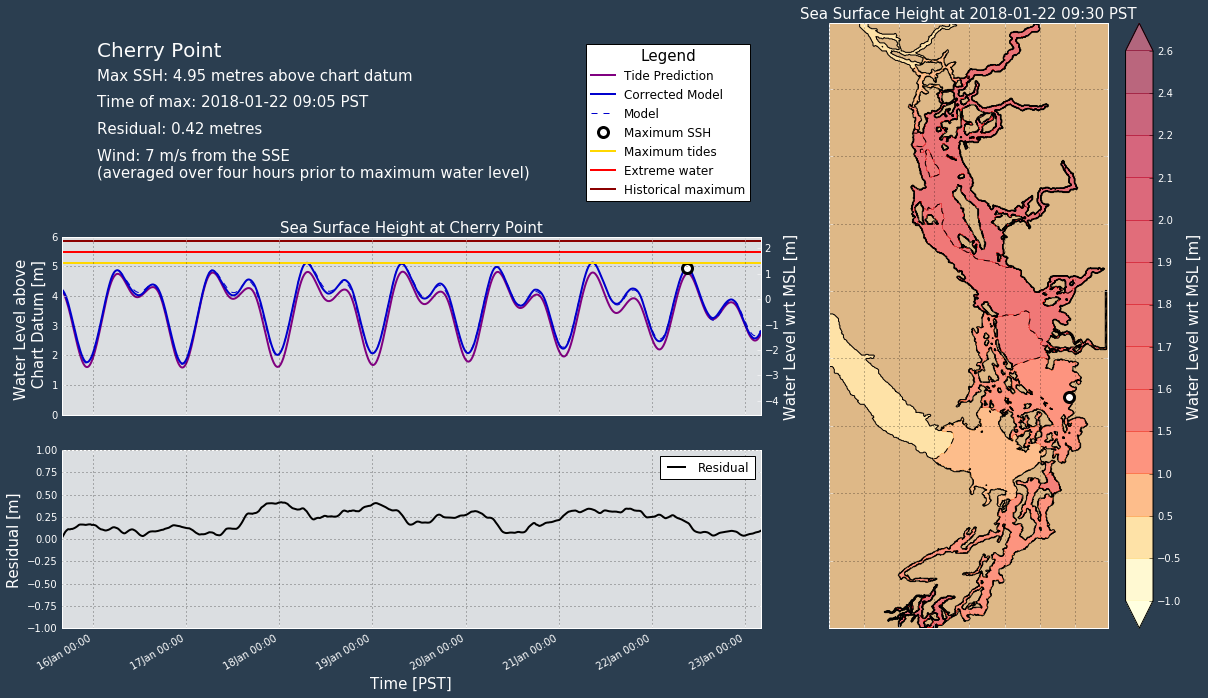

In [17]:
%%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme
reload(website_theme)

# tidal_predictions = '/results/nowcast-sys/SalishSeaNowcast/tidal_predictions/'
tidal_predictions = Path('/tmp/tide_analysis_scripts/')
weather_path = Path('/results/forcing/atmospheric/GEM2.5/operational/fcst/')
bathy = netCDF4.Dataset(Path('/results/nowcast-sys/grid/bathymetry_201702.nc'))
grid_T_hr_path = Path('/results/SalishSea/forecast/21jan18/SalishSea_1h_20180122_20180123_grid_T.nc')

fig = make_figure(
    'Cherry Point', tidal_predictions, weather_path, bathy, grid_T_hr_path,
)